# Anomaly Detection: Probabilistic Methods (Discrete)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Wrangle Data

In [3]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [4]:
# create SQL connection to logs
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'   
query = 'SELECT * FROM api_access'
df = pd.read_sql(query, url)

# parse the log entries
df = df.entry.apply(parse_log_entry)

#create the column for megabite size
#divide by 1024 twice
df['size_mb'] = df['size'] / 1024 / 1024
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


### `timestamp`

In [5]:
#### Count

# make timestamp datetime
df.timestamp = pd.to_datetime(df.timestamp)
# make timestamp the index
df = df.set_index('timestamp')
# resample by hour
timestamp_df = df.resample('H').size().reset_index(name='count')
timestamp_df

,timestamp,count
0,2019-04-16 19:00:00,2244
1,2019-04-16 20:00:00,4587
2,2019-04-16 21:00:00,3430
3,2019-04-16 22:00:00,1684
4,2019-04-16 23:00:00,2
5,2019-04-17 00:00:00,8
6,2019-04-17 01:00:00,380
7,2019-04-17 02:00:00,284
8,2019-04-17 03:00:00,807
9,2019-04-17 04:00:00,209


In [6]:
#### Frequency
# get a percentage count of requests per hour and append to timestamp_df
timestamp_df['pct_of_total'] = timestamp_df['count'] / timestamp_df['count'].sum()
# sort by pct_of_total
timestamp_df = timestamp_df.sort_values(by='pct_of_total', ascending=False)
timestamp_df

,timestamp,count,pct_of_total
1,2019-04-16 20:00:00,4587,0.328252
2,2019-04-16 21:00:00,3430,0.245456
0,2019-04-16 19:00:00,2244,0.160584
3,2019-04-16 22:00:00,1684,0.120510
8,2019-04-17 03:00:00,807,0.057750
6,2019-04-17 01:00:00,380,0.027193
7,2019-04-17 02:00:00,284,0.020323
10,2019-04-17 05:00:00,253,0.018105
9,2019-04-17 04:00:00,209,0.014956
17,2019-04-17 12:00:00,70,0.005009


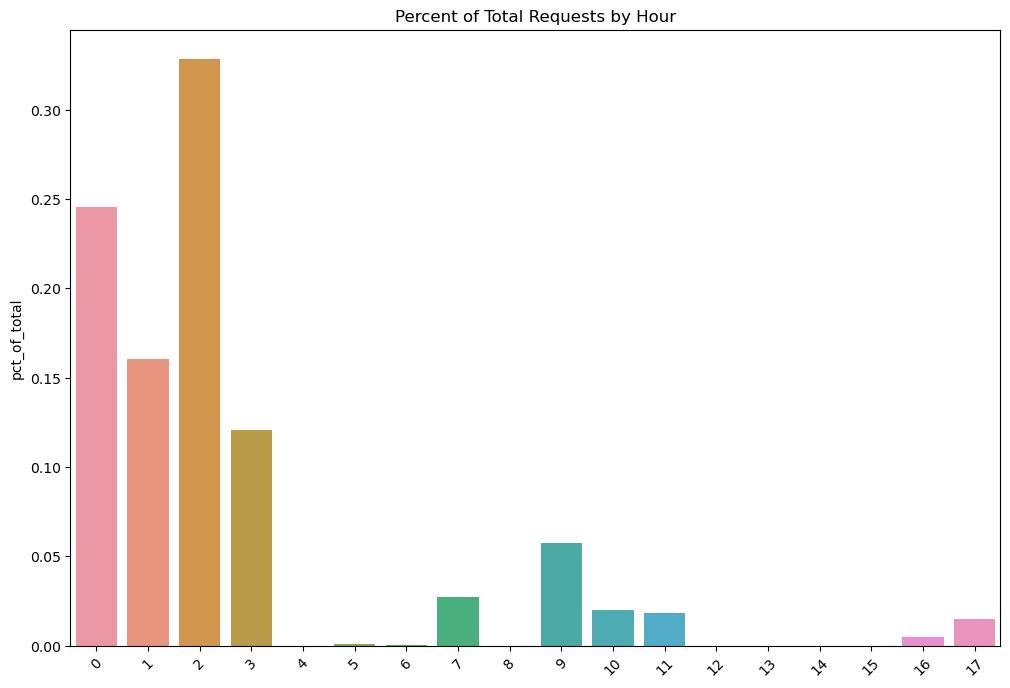

In [7]:
#### Vizualize
# vizualize the pct_of_total by hour sort by index
plt.figure(figsize=(12, 8))
sns.barplot(data=timestamp_df.sort_index(), x=timestamp_df.index, y='pct_of_total')
plt.xticks(rotation=45)
plt.title('Percent of Total Requests by Hour')
plt.show()


### `request_method`

In [8]:
df.request_method.value_counts()

request_method
GET    13974
Name: count, dtype: int64

In [9]:
#### Count
# use value_counts to get a count of unique values in request_method
df.request_method.value_counts()

request_method
GET    13974
Name: count, dtype: int64

In [10]:
#### Frequency
# use value_counts(normalize=True) to get a count of unique values in request_method, expressed as a percentage of the total
df.request_method.value_counts(normalize=True)

request_method
GET    1.0
Name: proportion, dtype: float64

> Takeaways: There are no anomalous observations in regards to request_method

### `request_path`

In [11]:
#### Count
# use value_counts to get a count of unique values in request_path and save to a new df
request_path_df1 = df.request_path.value_counts().reset_index()
request_path_df1

,request_path,count
0,/api/v1/sales?page=2,709
1,/api/v1/items,464
2,/api/v1/items?page=2,291
3,/api/v1/items?page=3,219
4,/api/v1/stores,162
...,...,...
213,/api/v1/items?page=0,1
214,/api/v1/stores?page=999,1
215,/api/v1/stores?page=2,1
216,/api/v1/stores?page=666,1


In [12]:
#### Frequency

# use value_counts(normalize=True) to get a count of unique values in request_path, expressed as a percentage of the total
df.request_path.value_counts(normalize=True)

# save to a new dataframe
request_path_df2 = pd.DataFrame(df.request_path.value_counts(normalize=True)).reset_index().\
                rename(index=str, columns={'index': 'request_path', 'proportion': 'probability'})
request_path_df2

,request_path,probability
0,/api/v1/sales?page=2,0.050737
1,/api/v1/items,0.033205
2,/api/v1/items?page=2,0.020824
3,/api/v1/items?page=3,0.015672
4,/api/v1/stores,0.011593
...,...,...
213,/api/v1/items?page=0,0.000072
214,/api/v1/stores?page=999,0.000072
215,/api/v1/stores?page=2,0.000072
216,/api/v1/stores?page=666,0.000072


In [13]:
# merge the two request_path dataframes
request_path_df = pd.merge(request_path_df1, request_path_df2, how='inner',on='request_path')
request_path_df

,request_path,count,probability
0,/api/v1/sales?page=2,709,0.050737
1,/api/v1/items,464,0.033205
2,/api/v1/items?page=2,291,0.020824
3,/api/v1/items?page=3,219,0.015672
4,/api/v1/stores,162,0.011593
...,...,...,...
213,/api/v1/items?page=0,1,0.000072
214,/api/v1/stores?page=999,1,0.000072
215,/api/v1/stores?page=2,1,0.000072
216,/api/v1/stores?page=666,1,0.000072


In [14]:
# in request_path_df, show observations where probability is less than 0.4%
request_path_df[request_path_df.probability < 0.004]

,request_path,count,probability
192,/favicon.ico,26,0.001861
193,/api/v1//api/v1/items?page=2,10,0.000716
194,/api/v1/items/api/v1/items?page=2,6,0.000429
195,/api/v1/items/next_page,5,0.000358
196,/api/v1/stores?page=3,4,0.000286
197,/api/v1/,4,0.000286
198,/api/v1/itemsitems,3,0.000215
199,/api/v1/store,3,0.000215
200,/api/v1/sales/?page=2,3,0.000215
201,/api/v1/stores?page=0,2,0.000143


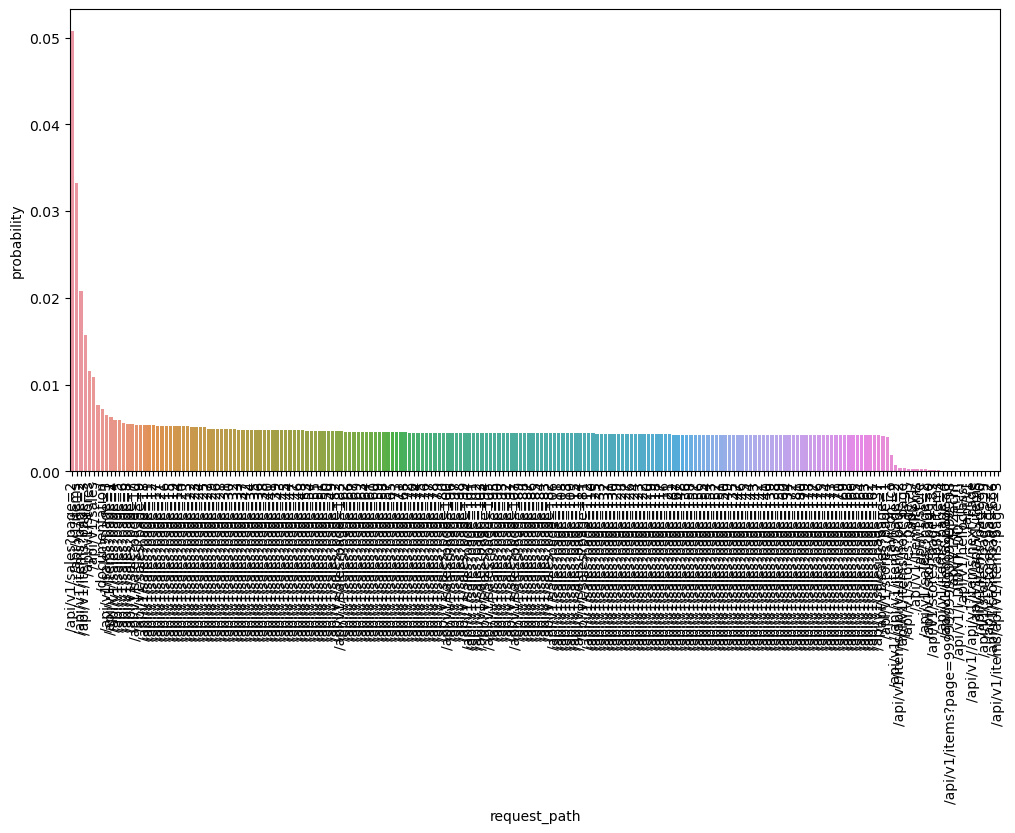

In [15]:
#### Vizualize
# vizualize the distribution of probabilities
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=request_path_df, x='request_path', y='probability')
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)
plt.show()


### `http_version`

In [16]:
#### Count
# get a count of each http_version
df.http_version.value_counts()

http_version
HTTP/1.1    13974
Name: count, dtype: int64

> Takeaways: There are no anomalous observations in regard to http_version

### `status_code`

In [17]:
#### Count
# get a count of each status_code and save to a new df
status_df1 = df.status_code.value_counts().reset_index().rename(columns={'index': 'status_code', 'status_code': 'status_code'})
status_df1

,status_code,count
0,200,13958
1,499,16


In [18]:
#### Frequency
# get a count of each status_code, expressed as a percentage of the total and save to a new df
status_df2 = df.status_code.value_counts(normalize=True).reset_index().rename(columns={'index': 'status_code', 'status_code': 'status_code'})
status_df2

,status_code,proportion
0,200,0.998855
1,499,0.001145


In [19]:
# Merge the status_count and status_proba dataframes
status_df = pd.merge(status_df1, status_df2, how='inner', on='status_code').sort_values(by='proportion', ascending=False)
status_df

,status_code,count,proportion
0,200,13958,0.998855
1,499,16,0.001145


> Successful Status codes are the vast majority of observations. A status of 499 happened just 0.11 % of the time

In [20]:
#### Conditional Probability
# what is the probability of a certain status code given the hour?

# add column to df that is the hour of the day
df['hour'] = df.index.hour

status_given_hour = (
    df.groupby('hour')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_hour

,hour,status_code,proba_status_given_ip
0,0,200,1.000000
1,1,200,1.000000
2,2,200,0.996479
3,2,499,0.003521
4,3,200,0.998761
5,3,499,0.001239
6,4,200,1.000000
7,5,200,1.000000
8,6,200,1.000000
9,10,200,1.000000


> Takeaways:
> 499 status codes are rare, but are most likely to happen in hour 0200 and least likely to happen in hour 2200.

### `size_mb`

In [21]:
#### Count
# get a count for each size_mb
df.size_mb.value_counts()

size_mb_df1 = df.size_mb.value_counts().reset_index()
size_mb_df1

,size_mb,count
0,0.471896,705
1,0.003396,548
2,0.003489,291
3,0.001266,229
4,0.001704,219
...,...,...
182,0.312356,1
183,0.343606,1
184,0.265481,1
185,0.327981,1


In [22]:
#### Frequency

# use value_counts(normalize=True) to get a count of unique values in size_mb as a percentage of total
df.size_mb.value_counts(normalize=True)

# save to a new dataframe
size_mb_df2 = pd.DataFrame(df.size_mb.value_counts(normalize=True)).reset_index().\
                rename(index=str, columns={'index': 'size_mb', 'proportion': 'probability'})
size_mb_df2

,size_mb,probability
0,0.471896,0.050451
1,0.003396,0.039216
2,0.003489,0.020824
3,0.001266,0.016388
4,0.001704,0.015672
...,...,...
182,0.312356,0.000072
183,0.343606,0.000072
184,0.265481,0.000072
185,0.327981,0.000072


In [23]:
# merge the two size_mb dataframes
size_mb_df = pd.merge(size_mb_df1, size_mb_df2, how='inner',on='size_mb')
size_mb_df

,size_mb,count,probability
0,0.471896,705,0.050451
1,0.003396,548,0.039216
2,0.003489,291,0.020824
3,0.001266,229,0.016388
4,0.001704,219,0.015672
...,...,...,...
182,0.312356,1,0.000072
183,0.343606,1,0.000072
184,0.265481,1,0.000072
185,0.327981,1,0.000072


> The most common size_mb was -0.471896. Looking at the count of unique size values may be helpful to find the very most common and very least common observations, but doesn't give us very interpretable insights. Perhaps it would be better to put size into buckets to make more discreet and explore that way.

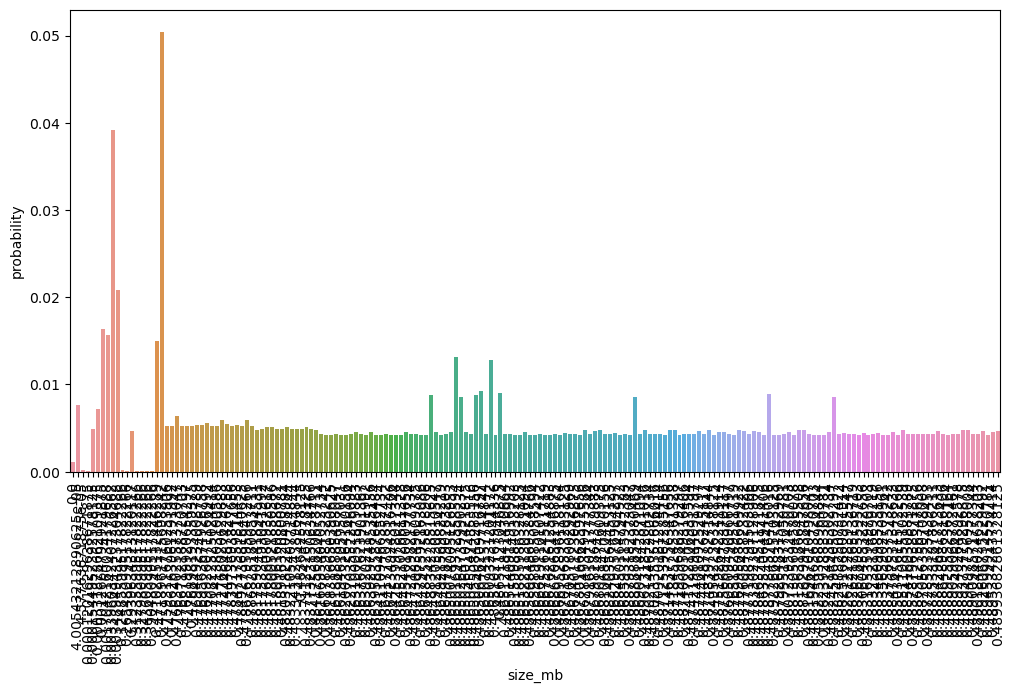

In [24]:
#### Vizualize
# vizualize the distribution of probabilities
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=size_mb_df, x='size_mb', y='probability')
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)
plt.show()


In [25]:
# in size_mb_df, show observations where probability is less than 0.4%
size_mb_df[size_mb_df.probability < 0.004]

,size_mb,count,probability
178,0.000000,16,0.001145
179,0.124856,3,0.000215
180,0.000046,3,0.000215
181,0.000120,1,0.000072
182,0.312356,1,0.000072
183,0.343606,1,0.000072
184,0.265481,1,0.000072
185,0.327981,1,0.000072
186,0.390481,1,0.000072


In [26]:
#### Conditional Probability
# What is the probability of a certain size_mb given ip address?
size_mb_given_ip = (
    df.groupby('ip')
    .size_mb.value_counts(normalize=True)
    .rename('proba_size_mb_given_ip')
    .reset_index()
)
size_mb_given_ip

,ip,size_mb,proba_size_mb_given_ip
0,173.173.113.51,0.003396,0.060434
1,173.173.113.51,0.001704,0.058546
2,173.173.113.51,0.003489,0.058546
3,173.173.113.51,0.001266,0.050992
4,173.173.113.51,0.486502,0.013220
...,...,...,...
740,97.105.19.58,0.343606,0.000083
741,97.105.19.58,0.000120,0.000083
742,97.105.19.58,0.265481,0.000083
743,97.105.19.58,0.312356,0.000083


### `user_agent`

In [27]:
#### Count
# get a count of each unique user_agent
user_agent_df = df.user_agent.value_counts().reset_index().rename(columns={'index': 'user_agent'})
user_agent_df

,user_agent,count
0,python-requests/2.21.0,12001
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


In [28]:
#### Frequency
# use value_counts(normalize=True) to get a count of unique values in user_agent, expressed as a percentage of the total
user_agent_df2 = pd.DataFrame(df.user_agent.value_counts(normalize=True)).reset_index().\
                rename(index=str, columns={'index': 'user_agent', 'proportion': 'probability'})
user_agent_df2

,user_agent,probability
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [29]:
# merge the two user_agent dataframes
user_agent_df = pd.merge(user_agent_df, user_agent_df2, how='inner',on='user_agent')
user_agent_df

,user_agent,count,probability
0,python-requests/2.21.0,12001,0.858809
1,python-requests/2.20.1,1911,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


> Takeaways: The majority of observations are user_agent(s) python-requests/2.21.0; python-requests/2.20.1. The slackbot makes a handful of requests, but not likely anomalous. However there are 4 different Mozilla users that could be anomalous.

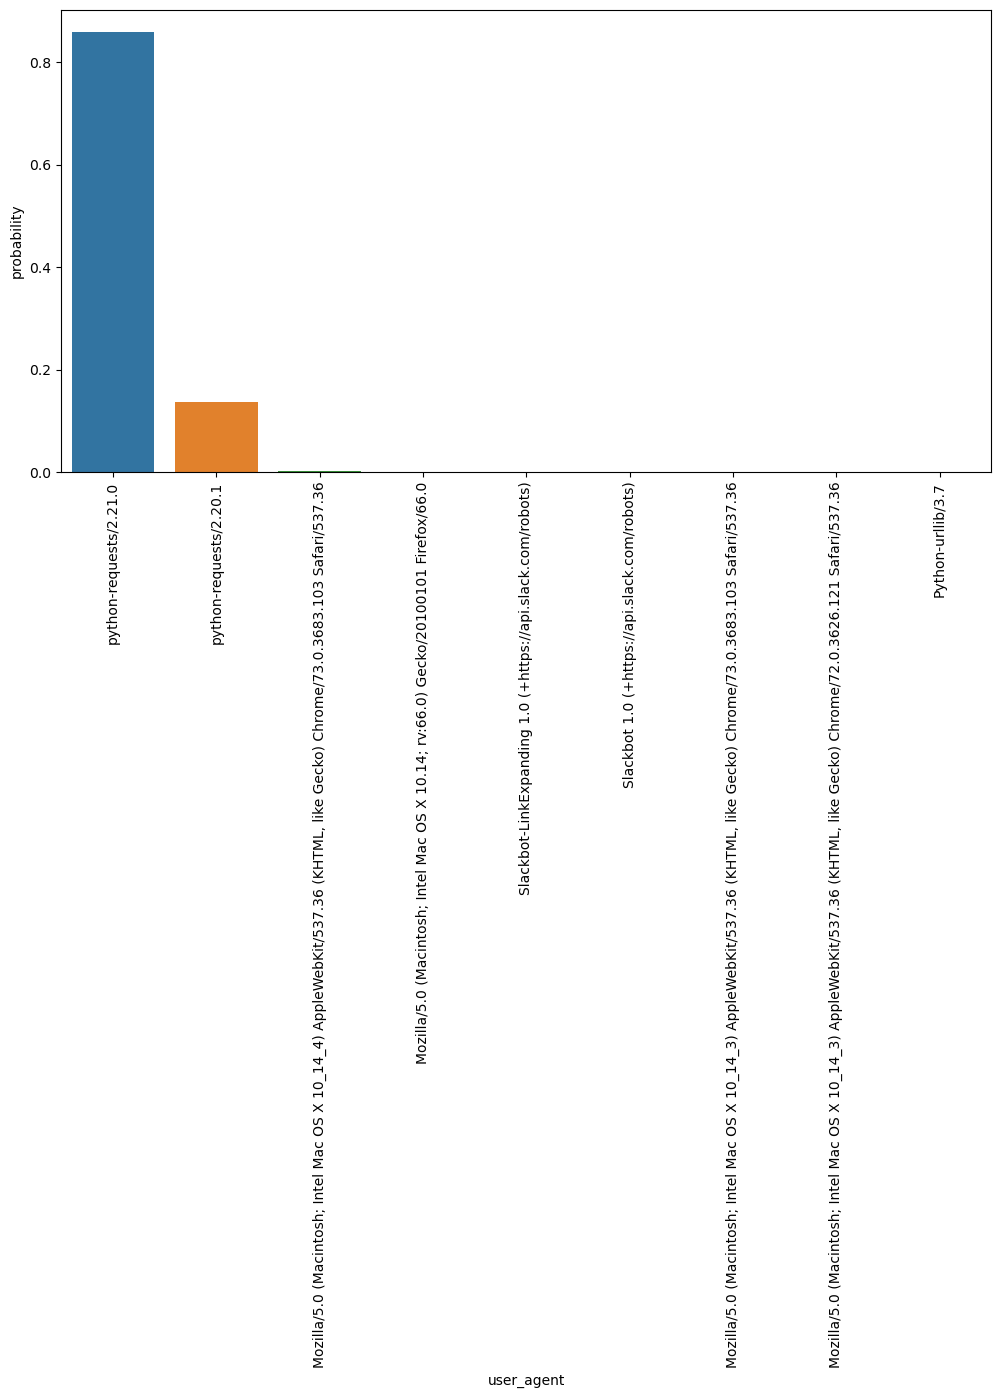

In [30]:
#### Vizualize
# vizualize the distribution of probabilities
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=user_agent_df, x='user_agent', y='probability')
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)
plt.show()


In [31]:
#### Conditional Probability
# What is the probability of a certain status code give the user_agent?
user_agent_given_status = (
    df.groupby('status_code')
    .user_agent.value_counts(normalize=True)
    .rename('proba_user_agent_given_status')
    .reset_index()
)
user_agent_given_status

,status_code,user_agent,proba_user_agent_given_status
0,200,python-requests/2.21.0,0.858934
1,200,python-requests/2.20.1,0.136624
2,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002436
3,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000573
4,200,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000502
5,200,Slackbot 1.0 (+https://api.slack.com/robots),0.000430
6,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000287
7,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,200,Python-urllib/3.7,0.000072
9,499,python-requests/2.21.0,0.750000


> Takeaway: Of the potential anomalous user_agents, all status_codes were successful

In [32]:
# find the mean size_mb for each user_agent
user_agent_size_mb = df.groupby('user_agent').size_mb.mean().reset_index().rename(columns={'size_mb': 'avg_size_mb'})
user_agent_size_mb.sort_values(by='avg_size_mb', ascending=False)

,user_agent,avg_size_mb
7,python-requests/2.20.1,0.471340
8,python-requests/2.21.0,0.424383
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.118616
6,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.068299
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.014421
4,Python-urllib/3.7,0.000154
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000097
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000097


> Takeaway: Size_mb was much smaller than dataset average for our potential anomalous user_agents.